Too Short; Want More?
# ユーチューブの動画を使って感情認識を行う長編ノートブック

筑波大学情報科学類４年スコットアトム [HP](http://atomscott.com/)

![あとでかっこいい画像に変える](./pics/front_cover_tmp.png)

<hr>

メインに次のライブラリを使う！

In [1]:
import sys,os,importlib
import time

import dlib
import face_recognition, face_alignment
import chainer
import chainercv

import numpy as np
import matplotlib.pyplot as plt
import my_utils as utls # 自分のコード


<hr>

## 目次

### 背景
- **既存の感情認識の方法**
    - 表情
        - Face Detection
            - HOG + linear classifier + image pyramid + sliding window 
            - SSD + ResNet10
            - FasterRCNNVGG16のFine Tune 
        - Face Landmark Detection
            - Ensemble of Regression Trees
            - Hour Glass CNN
        - Facial Emotion Recognition
    - 声色
    - その他
    

- **なぜデータセットを作る必要なのか** 
    - 既存のデータセットの概要
    - 日本語データセットを作ることの意義


### データセットの作成
- **対象人物の顔の辞書データを作成**
    - Web Scraping 対象人物の写真を集める　
    - Face Detection + ROI Cropping 写真の中から顔の写真を切り出す
    - Purification 対象人物以外の写真を除外する


- **対象人物の発話シーケンスを作成**
    - Web Scraping 対象人物の動画を集める
    - Scene Change Detection 動画をシーンごとに分ける
    - Face Recognition + ROI Cropping 辞書データをもとに対象人物の顔のみを切り出す
    - Active Speaker Verification
 
### Student - Teacher モデルで音声による感情認識モデルの作成
- **実験**

- **Ablation Study**

### 作成したモデルの検証

### ディスカッション・応用先の検討

### 最後に

*論文を書いたので読んでください！*

<hr>

## 背景

## 既存の感情認識の方法

### 表情を用いた感情認識

人の感情を推定するときは表情が一番参考になる。よって、Facial Expression Recognition(FER)について多くの研究がなされており、様々なFERシステムが存在する。

日本では喜怒哀楽という四字熟語があり、感情を４つのカテゴリに分けることが主流なのかもしない。しかし、表情に関する研究の多くは：

- Anger
- Disgust
- Fear
- Happiness
- Sadness
- Suprise

のカテゴリに感情を分けているようだ。

一昔前までは、顔の特徴を記述するモデルとして[Facial Action Coding System(FACS)](https://www.paulekman.com/facial-action-coding-system/)が使用されていた。FACSは表情をアクションユニット（AU）と呼ばれる筋肉の動きの個々の要素に分解するモデルで、今でもアニメーションなどに使われているらしい。

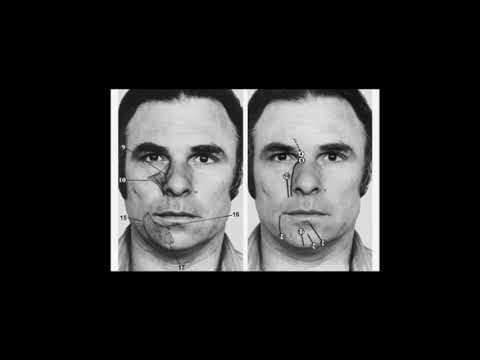

In [2]:
from IPython.display import Audio,Image, YouTubeVideo
YouTubeVideo(id='6RzCWRxnc84',width=600,height=300)

上にあげた動画に出てくるような理想的な状況下での顔面画像であれば、FACSは有効だが、"In the wild(野生の中で)"と呼ばれる状況、いわゆる普通のありふれた写真の感情認識は非常に難しい。

そもそも普通の写真ではどこに顔があるのかが分からない、あったとしても顔が正面を向いているとは限らないなど、多くの問題がある。

そのため、"In the wild"で表情認識を行う場合はFace Detection(顔認識)やFacial Alignmentと呼ばれる正規化などが前処理として必要になる。さらにFacial Alignmentを行うために顔のパーツ（鼻や目）を認識するFacial Landmark Detectionも行わなければならない。本当に大変である。

これらのハードルを乗り越えるために、近年ではCNNを用いたディープラーニングを用いた主流がメインになっている。それぞれについて詳細に説明すると本がかけしまうので、ここでは

- Face Detection
- Facial Landmark Detection

について、それぞれ一つのデータセットですぐに使えるモデルでどれだけの精度がでるのかを検証する。

<hr>

#### **Face Detection**

検証用データセット : [WIDER FACE](http://shuoyang1213.me/WIDERFACE/WiderFace_Results.html)


![](./pics/wider.jpg)

WIDER FACEについて
>WIDER FACE dataset is a face detection benchmark dataset, of which images are selected from the publicly available WIDER dataset. We choose 32,203 images and label 393,703 faces with a high degree of variability in scale, pose and occlusion as depicted in the sample images. 

3万2203枚の画像・39万3703面の顔が含まれている。
（そう、このノートブックはガチなんやで）

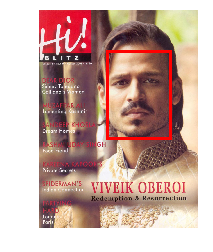

In [3]:
sys.path.append('./datasets/Wider_Face/')
from wider_face_dataset import WIDERFACEDataset

# Wider FaceのValidation用のデータ用意する
data_path = './datasets/Wider_Face/WIDER_val'
label_path = './datasets/Wider_Face/wider_face_split/wider_face_val.mat'
wider_face = WIDERFACEDataset(data_path, label_path)

# BBOX付きの写真は下のような感じ
img, bboxes, label = wider_face.get_example(320)
chainercv.visualizations.vis_bbox(img, bboxes)
plt.axis('off')
plt.show()

評価指標：Intersection over Union (IoU)に基づく「検出領域とアノテーション領域の交差の比率が0.5より大きい場合、スコアは１、それ以外の場合のスコアは0」という評価指標を用いる。

IoUの直感的なイメージ([src](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/))

![](./pics/iou.png)

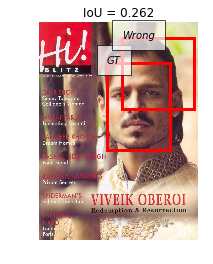

In [4]:
wrong_bbox = [[100., 535., 560., 1000.]] #自分でテキトーにBBOXを作る [y1, x1, y2, x2]
iou_score = utls.get_iou(wrong_bbox[0], bboxes[0]) #IoUスコアを計算する

chainercv.visualizations.vis_bbox(img, np.append(bboxes, wrong_bbox, axis=0), label=[0,1], label_names=['GT', 'Wrong']) 
plt.title('IoU = {:.3f}'.format(iou_score))
plt.axis('off')
plt.show()

使用する顔認識のモデルは次の３つである。いずれも手軽ですぐにOut of the Boxで使えることを意識した。

- HOG Based
- CNN Based 
- FasterRCNNVGG16のFine Tune ([FasterRCNNVGG16](https://chainercv.readthedocs.io/en/stable/reference/links/faster_rcnn.html), [src](https://www.kaggle.com/mksaad/wider-face-a-face-detection-benchmark/version/4#WIDER_val.zip))

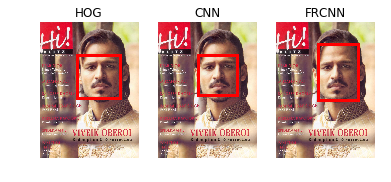

In [5]:
sys.path.append('./models/FasterRCNNVGG16_face_recognition/')
import FasterRCNNVGG16_face_recognition

sample_img = img.transpose(1,2,0).astype('uint8') #face_recognition用に配列順とtypeを変更

# HOG base & CNN baseのモデルface_recognitionモジュールからすぐに利用可能
HOG_out = face_recognition.face_locations(sample_img, number_of_times_to_upsample=0) # HOG baseの出力
CNN_out = face_recognition.face_locations(sample_img, number_of_times_to_upsample=0, model="cnn") # CNN baseの出力

# FasterRCNNVGG16ベースのモデルはモデルをダウンロードする必要がある
# その分面倒だが、chainerCVが使えてAIエンジニアっぽい！笑
TRAINED_MODEL = './models/FasterRCNNVGG16_face_recognition/snapshot_model_20180404.npz'

FRCNN_model = FasterRCNNVGG16_face_recognition.setup(TRAINED_MODEL)
# GPUを使わないといけないとMemory Errorになる可能性大！
FRCNN_out = FRCNN_model.predict([img])

# サンプル出力
utls.compare_bbox_images(img, HOG_out, CNN_out, FRCNN_out)

GPUを使うといかにスピードアップするか知っとくといい気がするので、一度だけ比較実験しましょうか。

In [6]:
# CPU Speed
s = time.time()
FRCNN_model.to_cpu()
_ = FRCNN_model.predict([img])
print("CPU inference took: {:.3f} secs".format(time.time()-s))

# GPU Speed 
s = time.time()
FRCNN_model.to_gpu(0)
_ = FRCNN_model.predict([img])
print("GPU inference took: {:.3f} secs".format(time.time()-s))

CPU inference took: 10.701 secs
GPU inference took: 6.040 secs


##### モデル比較

[ITERATION 0] HOG: 1, CNN: 1, FRCNN: 1, GT: 1


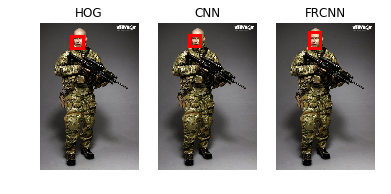

[ITERATION 10] HOG: 0, CNN: 1, FRCNN: 4, GT: 3


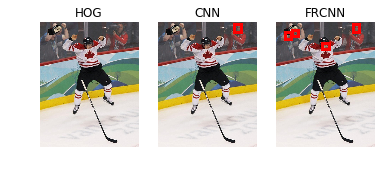

[ITERATION 20] HOG: 1, CNN: 1, FRCNN: 1, GT: 1


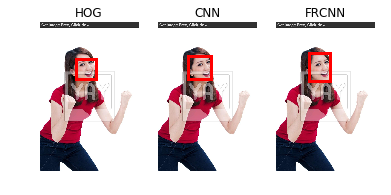

[ITERATION 30] HOG: 0, CNN: 1, FRCNN: 5, GT: 8


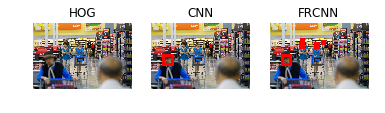

[ITERATION 40] HOG: 1, CNN: 1, FRCNN: 2, GT: 3


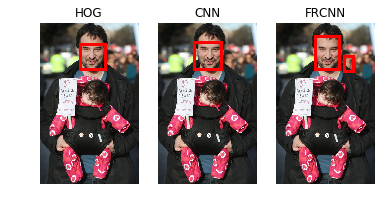

[ITERATION 50] HOG: 1, CNN: 2, FRCNN: 2, GT: 2


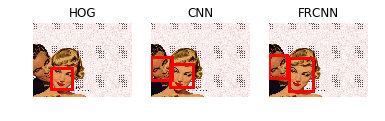

[FINAL] HOG: 0%, CNN: 0%, FRCNN: 45%


In [8]:
test_iter = chainer.iterators.SerialIterator(wider_face, batch_size=1,repeat=False, shuffle=True)

total_faces = 0
HOG_score = 0
CNN_score = 0
FRCNN_score = 0
for index, test_batch in enumerate(test_iter):
    test_img = np.asarray(test_batch[0][0])
    test_bboxes = np.asarray(test_batch[0][1])
    
    HOG_in = [test_img.transpose(1,2,0).astype('uint8')]
    HOG_out = [face_recognition.face_locations(frame, number_of_times_to_upsample=0) for frame in HOG_in][0]

    CNN_in = [test_img.transpose(1,2,0).astype('uint8')]
    CNN_out = [face_recognition.face_locations(frame, number_of_times_to_upsample=0, model="cnn") for frame in CNN_in][0] # CNN baseの出力
    
    FRCNN_in = [test_img]
    _FRCNN_out = FRCNN_model.predict(FRCNN_in)
    FRCNN_out = _FRCNN_out[0][0].astype('int')# 整形必要
    
    total_faces += len(test_bboxes) # Number of real faces
    HOG_score += utls.score_face_detection(HOG_out, test_bboxes) # Number of faces from HOG
    CNN_score += utls.score_face_detection(CNN_out, test_bboxes) # Number of faces from CNN
    FRCNN_score += utls.score_face_detection(FRCNN_out, test_bboxes) # Number of faces from FRCNN
    
    if index % 10 == 0:
        print("[ITERATION {0}] HOG: {1}, CNN: {2}, FRCNN: {3}, GT: {4}".format(index, len(HOG_out), len(CNN_out), len(FRCNN_out), len(test_bboxes)))
        utls.compare_bbox_images(test_img, HOG_out, CNN_out, _FRCNN_out)
        
    if index == 50:
        break
print("[FINAL] HOG: {0:.0%}, CNN: {1:.0%}, FRCNN: {2:.0%}".format(HOG_score/total_faces, CNN_score/total_faces, FRCNN_score/total_faces))

結果より、Wider Faceデータセットには群衆の写真など、顔認識を行うことが非常に難しいのが分かる。

Wider Faceデータセットを活用した、[Wider Challenge](http://wider-challenge.org/2019.html)というコンペが毎年、開催されており、2位になった[Insight Face](https://github.com/deepinsight/insightface_はFace DetectionとFacial Landmark Detectionの両方に関してState of the Artになっている。

手が回っていないが、ぜひいずれ実装したいと考えている。

<hr>

#### Facial Landmark Detection
検証用データセット：[iBUG 300-W](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/)

![](./pics/ibug.png)
(Fig 1.)

iBUG 300-Wについて
>The datasets LFPW, AFW, HELEN, and XM2VTS have been re-annotated using the mark-up of Fig 1. We provide additional annotations for another 135 images in difficult poses and expressions (IBUG training set). Annotations have the same name as the corresponding images. 

2万8827枚の写真に写っている顔に１面につき68点のラベルがアノテーションされている。

評価指標：目の端から端までの距離で顔の大きさを正規化してからの各点のユークリッド距離の平均

使用するモデル：

- One Millisecond Face Alignment with an Ensemble of Regression Trees by Vahid Kazemi and Josephine Sullivan ([paper](https://www.semanticscholar.org/paper/One-millisecond-face-alignment-with-an-ensemble-of-Kazemi-Sullivan/1824b1ccace464ba275ccc86619feaa89018c0ad) [src](http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html))
- <s>Stacked Hourglass Network for Robust Facial Landmark Localisation ([paper](http://openaccess.thecvf.com/content_cvpr_2017_workshops/w33/papers/Yang_Stacked_Hourglass_Network_CVPR_2017_paper.pdf) [src]())</s>いずれ実装したい
- How far are we from solving the 2D \& 3D Face Alignment problem by Adrian Bulat and Georgios Tzimiropoulos [paper](https://arxiv.org/abs/1703.07332) [src](https://github.com/1adrianb/face-alignment)

Bulat氏のモデルを使えば、off-the-shelfで3Dランドマークがすぐに手に入る！

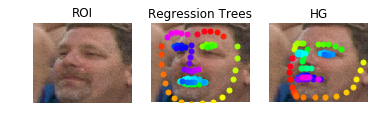

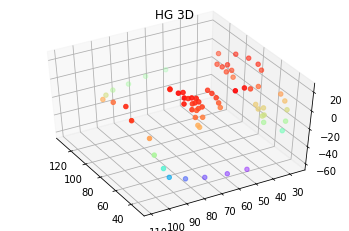

In [35]:
sys.path.append('./datasets/IBUG-300W/')
from ibug_300w import KeypointDataset
importlib.reload(utls)

data_path = '../../chainer-facial-hourglass/datasets/IBUG_300_W/*/*.png'
label_path = '../../chainer-facial-hourglass/datasets/IBUG_300_W/*/*.pts'
ibug_dataset = KeypointDataset(data_path, label_path, 'keypoints')

img, pts = ibug_dataset.get_example(50) # Get sample from dataset
bboxes = FRCNN_model.predict([img])[0][0].astype('int') # predict bboxes

_bbox_img = utls.crop_bbox(img, bboxes) # Crop to bbox
bbox_img = _bbox_img.transpose(1,2,0).astype('uint8')

# Ensemble of Regression Trees 
ERT_out = face_recognition.face_landmarks(bbox_img)

# 出力が辞書のリストなので、それを整形する
ERT_out = utls.unravel_list_dict(ERT_out)
ERT_out = ERT_out.reshape(len(ERT_out)//2, 2)

# Hourglass Model 
# 2d
HG2d = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)
HG2d_out = HG2d.get_landmarks(bbox_img)

# 3d
HG3d = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, flip_input=False)
HG3d_out = HG3d.get_landmarks(bbox_img)

# viz
utls.compare_landmark_images(_bbox_img, [ERT_out], HG2d_out)

from mpl_toolkits.mplot3d import Axes3D 

ax = plt.subplot(projection='3d')
xs, ys, zs = np.asarray(HG3d_out[0]).T
ax.scatter(xs, ys, zs, c=zs, cmap='rainbow', marker='o')
ax.view_init(45, 150)
ax.set_title("HG 3D")
plt.show()

##### モデル比較

(出力が異なるの一旦スキップ)

<hr>

#### Facial Emotion Recognition

Face DetectionとFacial Landmark Recognitionについて手軽なモデルを使ってどれくらいの精度が出るのかを理解したところで、次に表情認識についてより詳しく見てみよう。

以下が表情認識の一般的な流れだ。
![](./pics/face_pipeline.png)

表情認識には大きく分けて２つのタイプがある。

- Static Facial Emotion Recognition (画像に対して表情認識を行う)
    - Off-shelf-model Emopy
    
    
- Dynamic Facial Emotion Recognition
    - 動画に対して表情認識を行う。　

画像一枚に対して一つの感情を予測するStatic FERの方が、タスクとしてより簡単であること...


#### **Static Facial Emotion Recognition**
トレーンにFER Databaseの一部、テストにFER Databaseの一部とJapanese Female Facial Expression (JAFFE) Databaseを使います。
※両方を使って、テストが行えるように整形した箇所がいくつかあるので、リンクからダウンロードできるデータセットとは多少異なるところがあるかと思います。
主に、

- 画像サイズを統一する
- ラベルを統一する

ということを行いました。そのため、注意が必要です。

検証用データセット①: [FER](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data)

![](./pics/fer.png)

Microsoft FER+について
>The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

検証用データセット②: [JAFFE](https://zenodo.org/record/3451524#.XZQfPuYzZph)

![](./pics/jaffe.jpg)

JAFFEについて
>The database contains 213 images of 7 facial expressions (6 basic facial expressions + 1 neutral) posed by 10 Japanese female models. Each image has been rated on 6 emotion adjectives by 60 Japanese subjects. Images are 256x256 gray level, in .tiff format, with no compression.


In [ ]:
# Train a classifier here!

#### **Dynamic Facial Emotion Recognition**

一般的に時間軸方向の情報を含んだDynamic=ビデオでの表情認識はStatic=画像での表情認識よりはるかに難易度が高い。しかし、最近のディープラーニングのおかげで研究も進み、良さげなデータセットも増えてきた。ここでも２つのデータセット[MUG Facial Expression Database](https://mug.ee.auth.gr/fed/)と[CK+](http://www.consortium.ri.cmu.edu/ckagree/)を使う。

検証用データセット① [MUG Facial Expression Database](https://mug.ee.auth.gr/fed/)

![](./pics/mug.png)

>The images of 52 subjects are available to authorized internet users. The data that can be accessed amounts to 38GB. Twenty five subjects are available upon request and the rest 9 subjects are available only in the MUG laboratory. There are two parts in the database. In the first part the subjects were asked to perform the six basic expressions, which are anger, disgust, fear, happiness, sadness, surprise. The second part contains laboratory induced emotions.

検証用データセット② [CK+](http://www.consortium.ri.cmu.edu/ckagree/)

![](./pics/ck.png)

>Version 1, the initial release, includes 486 sequences from 97 posers. Each sequence begins with a neutral expression and proceeds to a peak expression.Version 2, referred to as CK+, includes both posed and non-posed (spontaneous) expressions and additional types of metadata. 

In [1]:
# Do tests and stuff

<hr>

### 声色を用いた感情認識

表情を用いた感情認識Facial Emotion RecognitionがFERと略されるのであれば、声色を用いた感情分析はどうなるのか？答えはSpeech Emotion Recognition, SERである。

- VGG-M [paper](https://arxiv.org/pdf/1405.3531.pdf)
- SoundNet [paper](http://soundnet.csail.mit.edu/)
- Deep Spectrum [paper](https://pdfs.semanticscholar.org/4bd0/f5bddf31961361cc5b16cca991e5c6aa8f5c.pdf)
- Conv Lstm with Attention [paper](https://pdfs.semanticscholar.org/c0f8/32808efa220dc64cf3dc5ed3aff4737484b5.pdf)

<hr>

### マルチモーダル

<hr>

### 転移学習

<hr>

## なぜデータセットを作る必要なのか

### 既存のデータセットの概要

### 日本語データセットを作ることの意義

<hr>
<hr>

# データセットの作成

## 対象人物の顔の辞書データを作成

### Web Scraping 対象人物の写真を集める　
    
### Face Detection + ROI Cropping 写真の中から顔の写真を切り出す
   
### Purification 対象人物以外の写真を除外する


## 対象人物の発話シーケンスを作成

### Web Scraping 対象人物の動画を集める

### Scene Change Detection 動画をシーンごとに分ける

### Face Recognition + ROI Cropping 辞書データをもとに対象人物の顔のみを切り出す

### Active Speaker Verification


<hr>
<hr>

# Student - Teacher モデルで音声による感情認識モデルの作成
